# Описание проекта

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. 

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Не важно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года. 

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков». 

Описание данных:
Name — название игры \
Platform — платформа \
Year_of_Release — год выпуска \
Genre — жанр игры \
NA_sales — продажи в Северной Америке (миллионы долларов) \
EU_sales — продажи в Европе (миллионы долларов) \
JP_sales — продажи в Японии (миллионы долларов) \
Other_sales — продажи в других странах (миллионы долларов) \
Critic_Score — оценка критиков (максимум 100) \
User_Score — оценка пользователей (максимум 10)\
Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию. \

Данные за 2016 год могут быть неполными.

**Цель:**
Для интернет-магазина, который продает по всему миру компьютерные игры, необходимо выявить закономерности, определяющие успешность компьютерной игры. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
from scipy import stats as st

## Ознакомление с данными

In [2]:
games = pd.read_csv('/datasets/games.csv')

In [3]:
games.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Имеются пропуски в некоторых колонках

### Общая информация о данных

In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Изменение типа данных 

**user_score** - значение этого столбца, как видно из таблицы, числовое. Меняем его на float64 \
**critic_score** - меняем значение на float64 \
**year_of_release** - меняем значение на Int64

### Пропуски

In [5]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        return mz_table
    
def missing_threshold(df):
    percent_of_nulls = (df.isnull().sum()/len(df)*100).sort_values().round(2)
    threshold = round(percent_of_nulls.mean(),2)
    return threshold

In [6]:
missing_zero_values_table(games)

,Zero Values,Missing Values,% of Total Values,Data Type
Critic_Score,0,8578,51.3,float64
Rating,0,6766,40.5,object
User_Score,0,6701,40.1,object
Year_of_Release,0,269,1.6,float64
Name,0,2,0.0,object
Genre,0,2,0.0,object


In [7]:
missing_threshold(games)

12.14

Данных очень мало по следующим столбцам: **Critic_Score**, **Rating**, **User_Score**. Среднее значение количества пропусков равна 12% \
Что делать: \
- **Critic_Score** - оценка критиков, возможно такой критерий появился намного позже, когда начала развиваться игровая индустрия. Заполнить их средним значением или медианой будет не правильно, а лучше будет присвоить значение -1. Так мы их не смешаем с рейтингом 0 \
- **Rating** - рейтинг от ERSB, возможно эта организация появилась позже. Аналогично первому случаю, поставим "No ERSB" \
- **User_Score** - думаю также не было сервисов, собирающий оценки от пользователей. Аналогично первому случаю, заполним значением -1 \
- **Year_of_Release** - всего 1.6% пропусков, изучим данные детальнее и решим как заполнить их 
- **Name**, **Genre** - поймем что делать, по результатам анализа, так как данных очень мало 

## Подготовка данных

In [8]:
def missing_data_in(col):
    return games[games[col].isnull()]

Для удобства переведем все названия колонок в нижний регистр

In [9]:
games.columns = games.columns.str.lower()

### Обработка пропусков

#### Название игры и жанр

In [10]:
missing_data_in('name')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Всего лишь две игры без названия, тем более не популярная платформа GEN. Думаю если мы удалим их, ничего критически не изменится

In [11]:
games.drop(missing_data_in('name').index, inplace=True)

#### Год выпуска

In [12]:
missing_data_in('year_of_release').head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


Предположим, что одна игра выпускалась на всех платформах 

In [13]:
games.query("name == 'Madden NFL 2004'")

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
1881,Madden NFL 2004,XB,2003.0,Sports,1.02,0.02,0.00,0.05,92.0,8.3,E
3889,Madden NFL 2004,GC,2003.0,Sports,0.40,0.10,0.00,0.01,94.0,7.7,E
5708,Madden NFL 2004,GBA,2003.0,Sports,0.22,0.08,0.00,0.01,70.0,6.6,E


Так и есть! Скорее всего тут была ошибка при выгрузке данных. Заполним эти данные из данных по другой платформе

In [14]:
not_null_values = games[games['year_of_release'].notnull()]

In [15]:
def fill_year_of_release(row, **kwargs):
    col = 'year_of_release'
    rows = not_null_values[not_null_values['name'] == row['name']]
    if len(rows) > 0:
        return rows.iloc[0][col]
    return row[col]

In [ ]:
games['year_of_release'] = games.apply(fill_year_of_release, axis=1).astype('Int64')

In [ ]:
len(missing_data_in('year_of_release'))

54% (146 из 269) пропусков удалось заполнить по колонке **year_of_release**

In [ ]:
games['year_of_release'] = games['year_of_release'].astype('Int64')

#### User_score

In [ ]:
games.query('critic_score.isnull() & rating.isnull() & user_score.isnull()')

Предположение неверно. По новым играм тоже есть пропуски по рейтингам

Формат столбца **user_score** - `object`, хотя там должны быть только `NaN` и числовые значения

In [ ]:
games['user_score'].unique()

Есть значение **tbd**, что скорее всего означает **to be defined**. Кажется не хватало голосов для выставления рейтинга. Возможно это касается непопулярных игр \
Т.к. **tbd** нам ничего не дает и по сути является `NaN`, приравняем значение его к `NaN`

In [ ]:
games['user_score'] = games['user_score'].replace('tbd', np.NaN)

In [ ]:
games['user_score'] = games['user_score'].fillna(-1)
games['user_score'] = games['user_score'].astype('float64')

#### Critic_score

In [ ]:
games['critic_score'] = games['critic_score'].fillna(-1)
games['critic_score'] = games['critic_score'].astype('Int64')

#### Rating

In [ ]:
games['rating'] = games['rating'].fillna('No ERSB')

### Проверка пропусков после обработки

In [ ]:
missing_zero_values_table(games)

In [ ]:
missing_threshold(games)

Как видно из таблицы и трешхолда, удалось существенно уменшить количество пропущенных значений

### Столбец с суммой продаж по всем регионам

In [ ]:
games['sales_total'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

In [ ]:
games.head()

## Исследовательский анализ данных

### Функция прорисовки графиков

In [ ]:
def graph(df, groupby_column, func, plt_name, y='name'):
    plt.style.use('bmh')
    df_to_plot = df.groupby(groupby_column)[y]
    if func == 'count':
        df_to_plot_calculated = df_to_plot.count()
    elif func == 'sum':
        df_to_plot_calculated = df_to_plot.sum().sort_values()
    figsize = (15,5)
    plot = df_to_plot_calculated.plot(kind='bar', y=y, figsize=figsize, ec='black')
    plt.xlabel(groupby_column)
    plt.ylabel(y)
    plt.title(plt_name)

### Количество выпущенных игр по годам

In [ ]:
graph(games, 'year_of_release', 'count', 'Количество выпущенных игр по годам', 'sales_total')

**Вывод:** \
Из графика видно, что количество игр на игровые приставки начало расти с 1994-го года. Вероятно, это связано с появлением на рынок приставки PlayStation. При чем рост был до 2008 года, а после начался спад, скорее всего из-за массовой разработки мобильных приложений, социальных сетей. Из-за этого интерес к играм на консолях резко начал падать

### Продажи по платформам

#### Продажи по платформам за весь период

In [ ]:
graph(games, 'platform', 'sum', 'Продажи по платформам за весь период','sales_total')

**Вывод:** \
Самый популярный PS2, действительно, в него играли все. Далее идут X360, PS3, Wii, DS, PS и т.д.

#### Измение продаж по платформам

In [ ]:
top_platforms = games.pivot_table(index='platform', values='sales_total', aggfunc='sum').sort_values('sales_total', ascending=False)
top_10 = top_platforms.head(10)
top_10

Отобрал TOP 10

In [ ]:
def sales_by_platform(name, df):
    return (
        df
            .query("platform == @name and year_of_release > 1994")
            .pivot_table(index='year_of_release', values='sales_total', aggfunc='sum')
            .sort_values('year_of_release', ascending=False)
    )

Данные до 1994-го года могут быть не интересны для анализа

In [ ]:
for platform in list(top_10.index):
    sales_by_platform(platform, games)['sales_total'].plot(figsize=(20, 15), label=platform)
    plt.xlabel("Год релиза", labelpad=10)
    plt.ylabel("Глобальные продажи", labelpad=50)
    plt.title("Глобальные продажи ТОП-10 платформ")
    plt.legend()

**Вывод:** \
Примерно **10 лет** продолжительность жизни игровой платформы, в течении которой она приносит деньги

### Какие платформы лидируют по продажам, растут или падают

In [ ]:
def total_sales_per_platform_for(df):
    return (
        df
            .pivot_table(index='platform', values='sales_total', aggfunc='sum')
            .sort_values('sales_total', ascending=False)
    )

In [ ]:
actual_years = (games['year_of_release'] > 2014) & (games['year_of_release'] <= 2016)
actual_games = games.loc[actual_years]

In [ ]:
total_sales = total_sales_per_platform_for(actual_games)

#### Глобальные продажи за актуальный период

In [ ]:
graph(total_sales, 'platform', 'sum', 'Глобальные продажи за актуальный период', 'sales_total')

#### Какие платформы падают, какие растут

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# список платформ за актуальный период
platforms = list(total_sales.index)

# график из 6 строк
rows = 6
cols = (len(platforms) // rows)
fig, ax = plt.subplots(rows, cols)

# построение графиков продаж по каждой платформе
num = 0
for row in range(rows):
    for col in range(cols):
        platform = platforms[num]
        (
            sales_by_platform(platform, actual_games)['sales_total']
                .plot(ax=ax[row, col], figsize=(20, 20), title=platform)
                .set(xlabel='Год релиза', ylabel='Глобальные продажи')
        )
        num += 1

plt.tight_layout()
plt.show()


**Вывод:** \
По графика видно, что эра платформ приходит к концу и продажи падают. Самый пик наступает после 5 лет после выхода приставки. У Wii был резкий скачок в 2009-м году и такой же спад после. 

#### «Ящик с усами» по глобальным продажам игр в разбивке по платформам

In [ ]:
top_10 = top_10.reset_index().rename_axis(None, axis=1)
top_10_list = top_10['platform']

In [ ]:
df_top_10_list = actual_games[actual_games['platform'].isin(top_10_list)]
df_top_10_list = df_top_10_list[df_top_10_list['sales_total']<1.4]

In [ ]:
df_top_10_list['sales_total'].describe()

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_top_10_list, x='platform', y='sales_total')
plt.title('Ящик с усами', fontsize=15)
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Глобальные продажи',fontsize=12)

**Вывод**:
- Медиана по топопвым платформам варьируется от 0,025 до 0,1 млн долларов прибыли за игру
- Больше всех продаж у PS4(0,7 млн), X360(0,5 млн ) и PC(0,3 млн)

### Как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков

In [ ]:
ps4 = actual_games.query("platform == 'PS4'")
xone = actual_games.query("platform == 'XOne'")

In [ ]:
features = ['user_score', 'critic_score', 'sales_total']
ps4[features].corr()

,user_score,critic_score,sales_total
user_score,1.000000,0.882016,0.069782
critic_score,0.882016,1.000000,0.179800
sales_total,0.069782,0.179800,1.000000


In [ ]:
xone[features].corr()

,user_score,critic_score,sales_total
user_score,1.000000,0.747776,0.037058
critic_score,0.747776,1.000000,0.201087
sales_total,0.037058,0.201087,1.000000


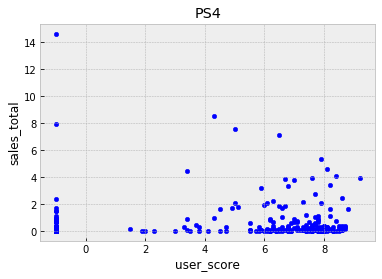

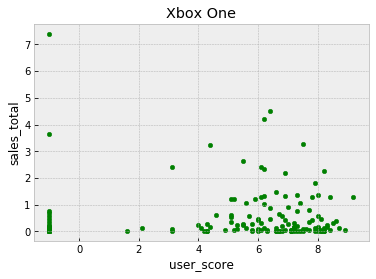

In [ ]:
ps4.plot(x='user_score', y='sales_total', kind='scatter', title='PS4')
xone.plot(x='user_score', y='sales_total', kind='scatter', title='Xbox One', color='green')
plt.show()

**Вывод:** 
- Взаимосвязи между отзывами пользователей и продажами нет
- Иногда игра собирает хорошие продажи благодаря маркетингу, но потом пользователи ставят низкий рейтинг, потому что игра их разочаровала

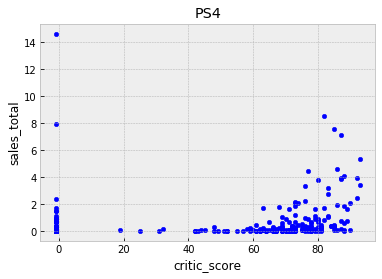

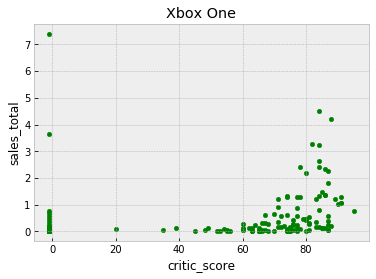

In [48]:
ps4.plot(x='critic_score', y='sales_total', kind='scatter', title='PS4')
xone.plot(x='critic_score', y='sales_total', kind='scatter', title='Xbox One', color='green')
plt.show()

**Вывод:**
- Взаимосвязь между отзывами критиков и продажами существует, однако не слишком большая
- С увеличением среднего рейтинга критиков увеличивается и средний уровень выручки с продажи игр, что логично: чем качественнее игра, тем больше денег она приносит разработчику и издателю
- Сильнее всего на конечную стоимость влияет оценка критиков. Практически не влияет - оценка пользователей.


### Расрпределение игр по жанрам

In [49]:
genre_sales = actual_games.pivot_table(index='genre', values='sales_total', aggfunc='sum')
genre_sales.sort_values('sales_total', ascending=False)

,sales_total
genre,
Shooter,105.15
Action,96.49
Sports,64.34
Role-Playing,52.44
Misc,13.50
Adventure,11.98
Fighting,11.67
Racing,10.86
Platform,9.28


Text(0, 0.5, 'Глобальные продажи')

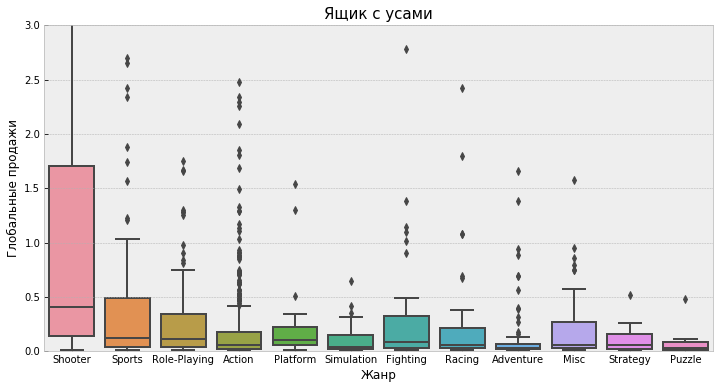

In [50]:
plt.figure(figsize=(12,6))
sns.boxplot(data=actual_games, x='genre', y='sales_total')
plt.ylim(0,3)
plt.title('Ящик с усами', fontsize=15)
plt.xlabel('Жанр', fontsize=12)
plt.ylabel('Глобальные продажи',fontsize=12)

Посмотрим жанр самой продаваемой игры:

In [51]:
actual_games.pivot_table(index=['name', 'genre', 'platform'], values='sales_total', aggfunc='sum').nlargest(10, 'sales_total')

,,,sales_total
name,genre,platform,
Call of Duty: Black Ops 3,Shooter,PS4,14.63
FIFA 16,Sports,PS4,8.58
Star Wars Battlefront (2015),Shooter,PS4,7.98
FIFA 17,Sports,PS4,7.60
Call of Duty: Black Ops 3,Shooter,XOne,7.39
Fallout 4,Role-Playing,PS4,7.17
Pokemon Sun/Moon,Role-Playing,3DS,7.14
Uncharted 4: A Thief's End,Shooter,PS4,5.39
Uncharted: The Nathan Drake Collection,Action,PS4,4.62


Ожидаемо, что самые продаваемые игрs на PS4 жанров shooter и sports

**Вывод:**
- Самыми популярными жанрами ожидаемо являются шутеры, экшн, а также спортивные игры. Хуже всего продаются стратегии и пазлы

<div class="alert alert-block alert-success">
Комментарий ревьюера v. 2:
    
Молодец, Ты верно определил наиболее популярные жанры. Однако было бы здорово попробовать объяснить эти предпочтения.
</div>

## Портрет пользователя каждого региона

### Функция для прорисовки графиков

In [52]:
def top_in_regions_plot(groupby, region_sales, ax):
    pivot = actual_games.groupby(groupby).agg({region_sales: 'sum'}).sort_values(by=region_sales, ascending=False)[:5]
    title_dict = {'na_sales': 'North America Sales', 'eu_sales': 'Europe Sales', 'jp_sales': 'Japan Sales'}
    color_dict = {'na_sales': None, 'eu_sales': 'gray', 'jp_sales': 'forestgreen'}
    plot = pivot.plot(kind='bar', ec='black', title=title_dict[region_sales], ax=axes[ax], 
                   fontsize=18, color=color_dict[region_sales], rot=20)
    plot.legend(prop={'size':17})
    plot.set_xlabel('')
    plot.title.set_size(20)

### Топ 5 популярных платформ в заданных регионах

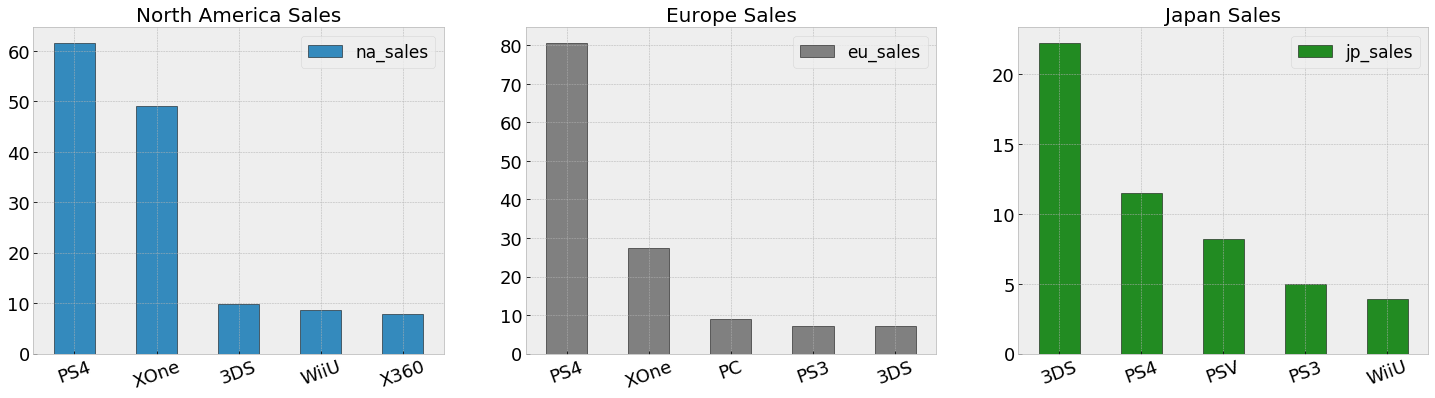

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_in_regions_plot('platform', 'na_sales', 0)
top_in_regions_plot('platform', 'eu_sales', 1)
top_in_regions_plot('platform', 'jp_sales', 2)

**Вывод:**
- Интересно что набор топ-5 платформ в Северной Америке и Европе одинаковый, различается лишь долями, а в Японии топ-5 совсем другой

<div class="alert alert-block alert-success">
Комментарий ревьюера v. 2:
    
Здесь можно было бы добавить какие именно платформы наиболее популярны в этих регионах и почему.
</div>

### Топ 5 популярных жанров в заданных регионах

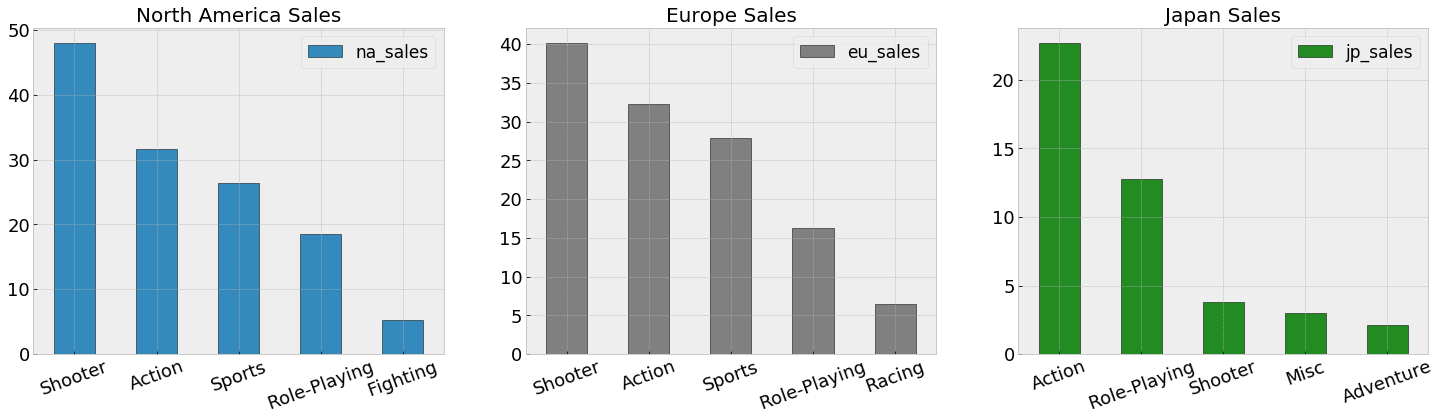

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_in_regions_plot('genre', 'na_sales', 0)
top_in_regions_plot('genre', 'eu_sales', 1)
top_in_regions_plot('genre', 'jp_sales', 2)

**Вывод**
- Топ 3 Северной Америки и Европы совпадают, отличаются лишь тем, что Сев. Америка предпочитает драки, а Европа гонки (ожидаемо, в Европе сильно развит автоспорт)
- В Японии наблюдаем немного другую картину, в топ 3 есть экшн, ролевые и шутеры, а вот 4 и 5 место занимают категории разное и приключения

### Влияние рейтинга ESRB на продажи в отдельном регионе

In [55]:
ESRB_dict = {'E': 'Для всех', 'M': '> 17 лет', 'T': '13-19 лет', 'E10+': '>10 лет', 'K-A': 'Для всех(устар.)'}

In [56]:
actual_games['ESRB_description'] = actual_games[actual_games['rating'].notnull()]['rating'].map(ESRB_dict)

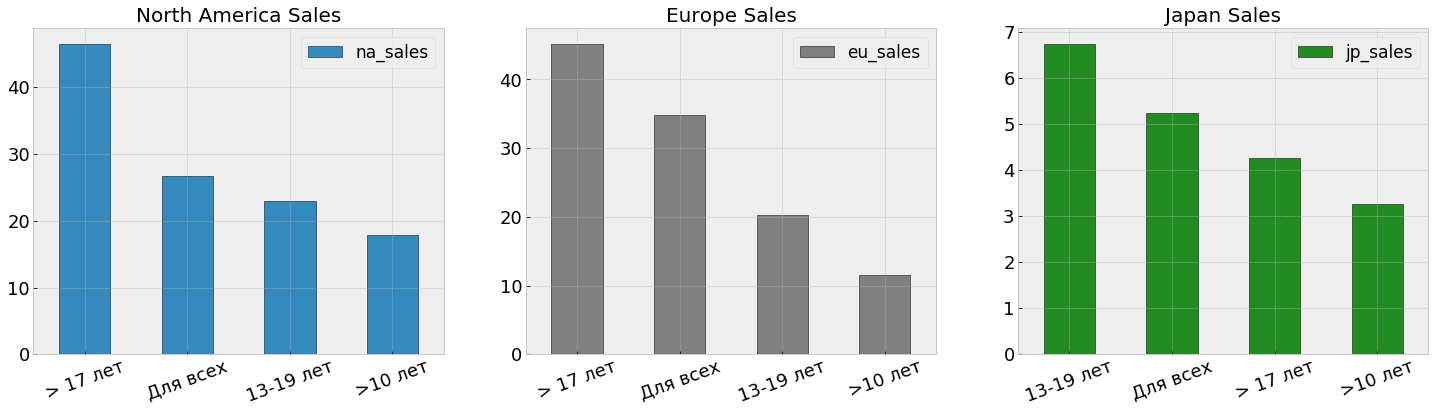

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_in_regions_plot('ESRB_description', 'na_sales', 0)
top_in_regions_plot('ESRB_description', 'eu_sales', 1)
top_in_regions_plot('ESRB_description', 'jp_sales', 2)

**Вывод**
- В Северной Америке и Европе картинка схожая, большая часть выручки получена с игр с рейтингом **>17 лет**
- В Японии доля рейтинга с **13-19 лет** больше 
- Запад и Восток отличаются, в Японии играют с раннего детства

<div class="alert alert-block alert-warning">
Комментарий ревьюера v. 1:
    
Поясни, пожалуйста, с чем связаны сходства и различия в предпочтениях по регионам.
</div>

## Проверка гипотез

### Гипотеза №1.

H0  — средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

H1  — средние пользовательские рейтинги платформ Xbox One и PC различаются.

α=1%

In [58]:
xone = actual_games.query('platform == "XOne"')['user_score']
pc = actual_games.query('platform == "PC"')['user_score']
alpha = .01

results = st.ttest_ind(
    xone, 
    pc, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.852060894758882
Не получилось отвергнуть нулевую гипотезу


In [59]:
xone_disp = np.var(xone, ddof=1)
pc_disp = np.var(pc, ddof=1)
print('Дисперсия "XOne" =', xone_disp)
print('Дисперсия "PC"  =', pc_disp)

Дисперсия "XOne" = 11.567542697804114
Дисперсия "PC"  = 10.53038454216638


Мы могли бы избавиться от выбросов в данных, но тогда был бы риск потерять часть данных за какой-то промежуток времени из выборочных совокупностей. \
При оспользовании метода проверки `ttest_ind`, значение `True` ставится когда равные дисперсии генеральной совокупности, поэтому был выбран параметр `False`. Расчеты привел выше

In [60]:
xone_pc = actual_games.query('platform == "XOne" or platform == "PC"')
xone_pc.pivot_table(index='platform', values='user_score', aggfunc='mean')

,user_score
platform,
PC,4.926214
XOne,4.847368


**Вывод**
- Статистический тест показал, что гипотезу не получилось отвергнуть. Если бы мы утверждали, что средние рейтинги для этих платформ различаются, мы бы допустили ошибку с вероятностью 20%

### Гипотеза №2.

H0  — средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») одинаковые.

H1  — средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.

α=1%

In [61]:
action = actual_games.query('genre == "Action"')['user_score']
sports = actual_games.query('genre == "Sports"')['user_score']
alpha = .01

results = st.ttest_ind(
    action, 
    sports, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0005619861619114531
Отвергаем нулевую гипотезу


In [62]:
action_disp = np.var(action, ddof=1)
sports_disp = np.var(sports, ddof=1)
print('Дисперсия жанра "Action" =', action_disp)
print('Дисперсия жанра "Sports"  =', sports_disp)

Дисперсия жанра "Action" = 15.916128725155396
Дисперсия жанра "Sports"  = 9.903506403599865


In [63]:
action_sports = actual_games.query('genre == "Action" or genre == "Sports"')
action_sports.pivot_table(index='genre', values='user_score', aggfunc='mean')

,user_score
genre,
Action,2.511139
Sports,3.779630


# Общий вывод

Данный анализ показал, что потенциально успешный продукт, должен обладать рядом характеристик:
- Игра должна быть разработана для платформ PS4 и Xone, если речь идет о Японии, то на платформе 3DS
- **Action**, **Shooter** для Запада, **Role-Playing** - для Японии
- Рейтинг ESRB: **от 17 лет** для Запада или **от 13 лет** для Японии. Рейтинг **Для всех** подойдет всем
- Ориентироваться на оценки пользователей нет смысла, но стоит обратить внмание на оценки критиков
- В целом рынок "погибает" с развитием мобильных игр. Все гонятся за технологиями, графикой и в связи с этим бюджет на разработку расет, что в целом сказывается на конечной стоимости игры 